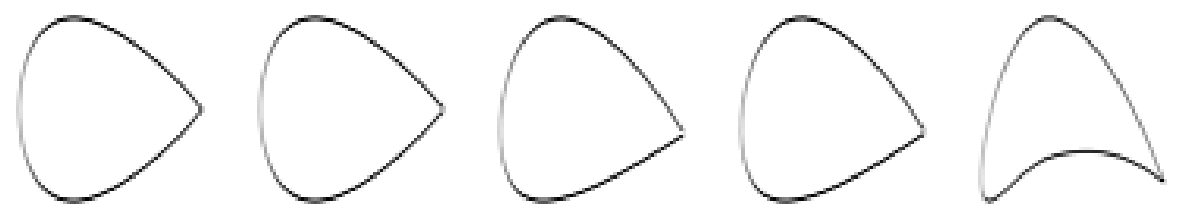

In [64]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Load and preprocess images
def load_images(image_dir, img_size=(64, 64)):
    images = []
    for filename in os.listdir(image_dir):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            img_path = os.path.join(image_dir, filename)
            img = Image.open(img_path).convert('L').resize(img_size)  # Convert to grayscale
            img = np.array(img) / 255.0
            img = np.expand_dims(img, axis=-1)  # Add channel dimension
            images.append(img)
    return np.array(images)

# Set the path to your images directory
image_dir = "C:\\working_space\\airfoil_project\\airfoil"  # Update this path to your image directory

# Load images
images = load_images(image_dir)

# Check if images are loaded correctly by visualizing a few of them
def visualize_images(images, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 15))
    for i in range(num_images):
        if i < len(images):
            axes[i].imshow(images[i].squeeze(), cmap='gray')
            axes[i].axis('off')
    plt.show()

visualize_images(images)


In [65]:
import numpy as np
from PIL import Image

# 이미지 파일 열기
image = Image.open("C:\\working_space\\airfoil_project\\airfoil\\n2414-il.png")
image_array = np.array(image)

# 이미지 채널 수 확인
if len(image_array.shape) == 2:
    print("그레이스케일 이미지입니다.")
elif len(image_array.shape) == 3:
    if image_array.shape[2] == 3:
        print("RGB 이미지입니다.")
    elif image_array.shape[2] == 4:
        print("RGBA 이미지입니다.")


RGBA 이미지입니다.


Loaded 29 images with shape (28, 28, 1)


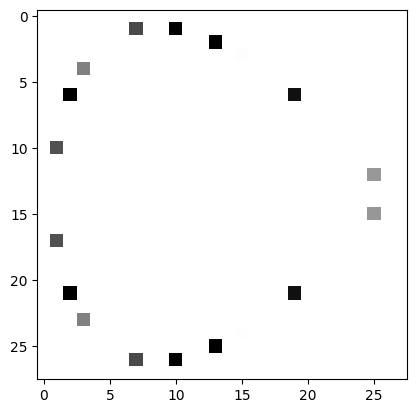

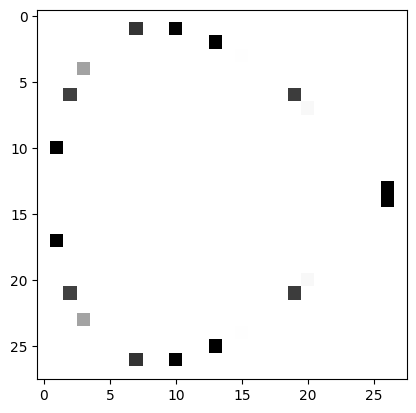

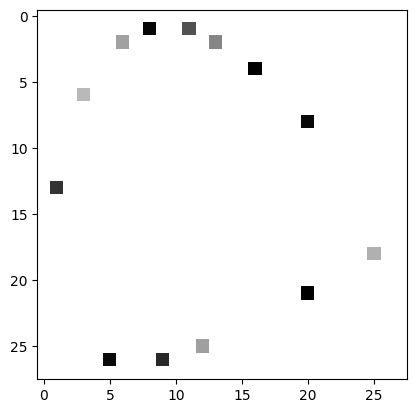

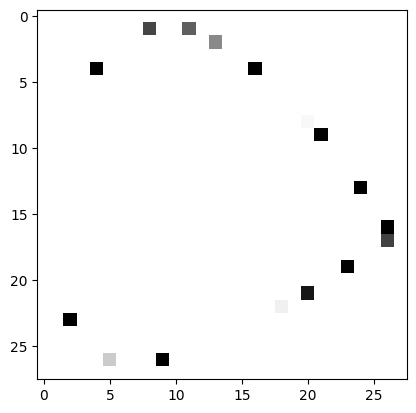

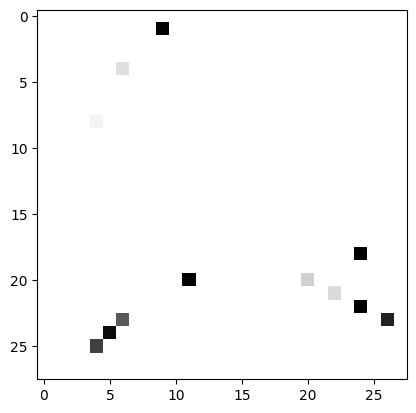

In [ ]:
import os
import numpy as np
from keras.preprocessing.image import load_img, img_to_array

def load_images_without_classes(dataset_path, target_size=(28, 28)):
    images = []
    for filename in os.listdir(dataset_path):
        if filename.endswith((".jpg", ".png")):  # 이미지 파일 형식 필터링
            img_path = os.path.join(dataset_path, filename)
            img = load_img(img_path, target_size=target_size, color_mode='grayscale')
            img_array = img_to_array(img)
            img_array = (img_array / 127.5) - 1  # 이미지 스케일링 [-1, 1]
            images.append(img_array)
    return np.array(images)

# 예시 데이터셋 경로
dataset_path = "C:\\working_space\\airfoil_project\\airfoil"

# 데이터 로드
images = load_images_without_classes(dataset_path)

# 로드한 이미지의 형태 출력
print(f'Loaded {images.shape[0]} images with shape {images.shape[1:]}')

# 배치 중 일부 이미지를 확인해보자
try:
    if images.size == 0:
        print("No images found.")
    else:
        # 이미지 시각화
        for i in range(min(5, images.shape[0])):
            plt.imshow(images[i].reshape(28, 28), cmap='gray')
            plt.show()
except Exception as e:
    print(f"Error loading images: {e}")


X_train: (23, 56, 56, 1)
X_test: (6, 56, 56, 1)
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential_2 (Sequential)   (None, 56, 56, 1)         2756609   
                                                                 
Total params: 2756609 (10.52 MB)
Trainable params: 2756225 (10.51 MB)
Non-trainable params: 384 (1.50 KB)
_________________________________________________________________
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 56, 56, 1)]       0         
                                                                 
 sequential_3 (Sequential)   (None, 1)                 406017    
                    

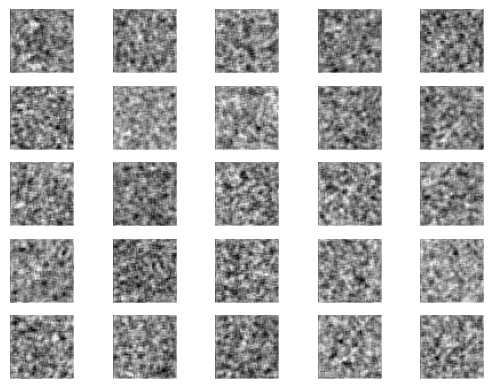

1/1 [==============================] - 0s 122ms/step


KeyboardInterrupt: 

In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization, LeakyReLU, UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import cv2 as cv
from sklearn.model_selection import train_test_split


file_path = "C:\\working_space\\airfoil_project\\airfoil"
def img_read(file_path, file):
    img = cv.imread(file_path + '//' + file, cv.IMREAD_GRAYSCALE)
    img = cv.resize(img, (56, 56))
    return img

def get_data():
    files = os.listdir(file_path)
    X = []
    for file in files:
        img = img_read(file_path, file)
        X.append((img - 127.5) / 127.5)
    X_train, X_test = train_test_split(X, test_size=0.2, random_state=1, shuffle=True)
    X_train = np.expand_dims(X_train, axis=3)
    X_test = np.expand_dims(X_test, axis=3)
    return np.array(X_train), np.array(X_test)

X_train, X_test = get_data()
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")


def build_generator():
    model = Sequential()

    model.add(Dense(128 * 14 * 14, activation="relu", input_dim=100))
    model.add(Reshape((14, 14, 128)))
    model.add(UpSampling2D())
    model.add(Conv2D(128, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(UpSampling2D())
    model.add(Conv2D(64, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(1, kernel_size=3, padding="same", activation='tanh'))

    noise = Input(shape=(100,))
    img = model(noise)

    return Model(noise, img)

generator = build_generator()
generator.summary()


def build_discriminator():
    model = Sequential()

    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=(56, 56, 1), padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    img = Input(shape=(56, 56, 1))
    validity = model(img)

    return Model(img, validity)

discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])
discriminator.summary()


discriminator.trainable = False

z = Input(shape=(100,))
img = generator(z)
valid = discriminator(img)

combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))
combined.summary()



def train(epochs, batch_size=128, sample_interval=50):
    REAL = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    history = []

    for epoch in range(epochs):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        noise = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(noise)

        d_loss_real = discriminator.train_on_batch(imgs, REAL)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        noise = np.random.normal(0, 1, (batch_size, 100))
        g_loss = combined.train_on_batch(noise, REAL)

        history.append({"D": d_loss[0], "G": g_loss})

        if epoch % sample_interval == 0:
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100 * d_loss[1], g_loss))
            sample_images(epoch)
    
    return history

def sample_images(epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_imgs = generator.predict(noise)
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    plt.show()

history = train(epochs=10001, batch_size=32, sample_interval=1000)
